In [1]:
import xarray as xr
import math
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch
import gpytorch
import matplotlib.pyplot as plt
import cf_units
import datetime
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

# Enter coordinates 
coords = (29, -90)   #NOLA

# Grab the approximate chunk for provided coords
area_approx = rechunked.sea_level.sel(xt_ocean=coords[1], yt_ocean=coords[0], method="nearest")

# Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
coords_dict = {'time': sea_level_picontrol['time']}
area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)

print(area_sea_level.time)

# Turn Data to tensors
time_array = cf_units.date2num(area_sea_level.time,'days since 0185-01-01 12:00:00' , calendar='julian')

print(area_sea_level.time.dtype)
print(type(time_array))

<xarray.DataArray 'time' (time: 5844)>
array([cftime.DatetimeJulian(185, 1, 1, 12, 0, 0, 0),
       cftime.DatetimeJulian(185, 1, 2, 12, 0, 0, 0),
       cftime.DatetimeJulian(185, 1, 3, 12, 0, 0, 0), ...,
       cftime.DatetimeJulian(200, 12, 29, 12, 0, 0, 0),
       cftime.DatetimeJulian(200, 12, 30, 12, 0, 0, 0),
       cftime.DatetimeJulian(200, 12, 31, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0185-01-01 12:00:00 ... 0200-12-31 12:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time
object
<class 'numpy.ndarray'>


In [3]:
def set_x_and_y(indexes, time, sea_level):
    
    x = []
    y = [] 

    for i in range(indexes[0],indexes[1]):
        x.append(time[i])
        y.append(sea_level[i])
        
    x = (np.array(x)).astype(float)
    y = (np.array(y)).astype(float)
   

    return x, y

indexes= {"train_range":[0,2000],"valid_range":[2001,3000],"test_range":[3001,5844]}
x_t, y_t = set_x_and_y(indexes["train_range"], time_array, area_sea_level)
x_v, y_v = set_x_and_y(indexes["valid_range"], time_array, area_sea_level)
x_te, y_te = set_x_and_y(indexes["test_range"], time_array, area_sea_level)
x_train = np.expand_dims(x_t, axis=1)
y_train = np.expand_dims(y_t, axis=1)
x_val = np.expand_dims(x_v, axis=1)
y_val = np.expand_dims(y_v, axis=1)
x_test = np.expand_dims(x_te, axis=1)
y_test = np.expand_dims(y_te, axis=1)
print(x_train.shape)


(2000, 1)


In [5]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(y_train)
val_arr = scaler.transform(y_val)
test_arr = scaler.transform(y_test)
print(x_train.shape)

(2000, 1)


In [6]:
# Splitting the data into sequences

def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [7]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

print(x_train.shape)
print(y_train.shape)


torch.Size([1900, 100])
torch.Size([1900, 100])


In [8]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled Sea")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

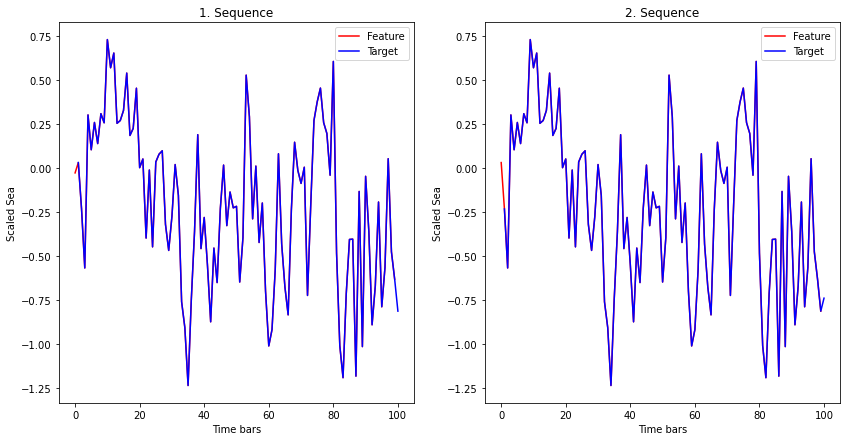

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [10]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [11]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        
print(x_train.shape)

torch.Size([1900, 100])


In [12]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [13]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [14]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [15]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch 1 Train loss: 1.03. Validation loss: 1.01. Avg future: 0.00. Elapsed time: 1.48s.
Epoch 2 Train loss: 0.92. Validation loss: 0.89. Avg future: 0.00. Elapsed time: 1.00s.
Epoch 3 Train loss: 0.80. Validation loss: 0.74. Avg future: 0.00. Elapsed time: 1.00s.
Epoch 4 Train loss: 0.65. Validation loss: 0.55. Avg future: 0.00. Elapsed time: 1.03s.
Epoch 5 Train loss: 0.46. Validation loss: 0.38. Avg future: 0.00. Elapsed time: 1.05s.
Epoch 6 Train loss: 0.37. Validation loss: 0.37. Avg future: 0.00. Elapsed time: 1.05s.
Epoch 7 Train loss: 0.36. Validation loss: 0.37. Avg future: 0.00. Elapsed time: 1.05s.
Epoch 8 Train loss: 0.35. Validation loss: 0.36. Avg future: 0.00. Elapsed time: 1.04s.
Epoch 9 Train loss: 0.34. Validation loss: 0.36. Avg future: 0.00. Elapsed time: 1.04s.
Epoch 10 Train loss: 0.33. Validation loss: 0.36. Avg future: 0.00. Elapsed time: 1.03s.
Epoch 11 Train loss: 0.33. Validation loss: 0.36. Avg future: 0.00. Elapsed time: 1.03s.
Epoch 12 Train loss: 0.33. Val

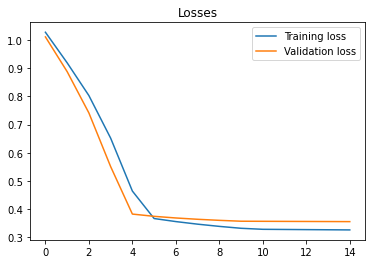

In [16]:
optimization_1.plot_losses()

Test loss 0.2503


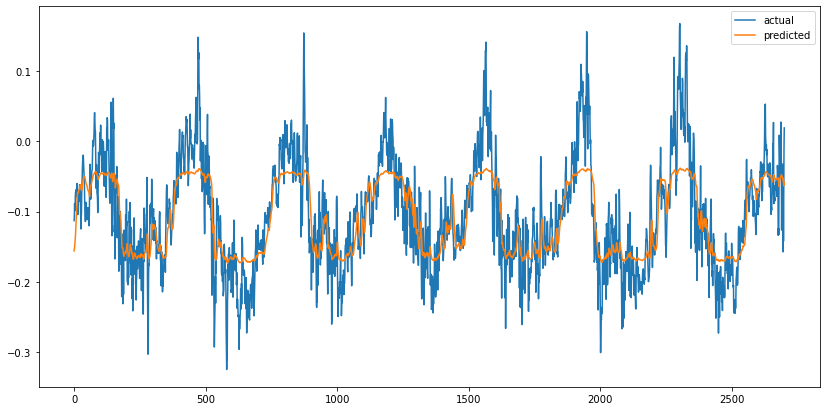

In [17]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

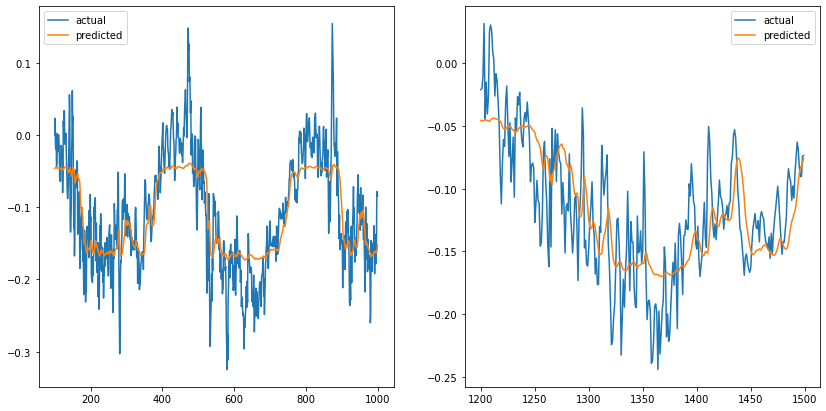

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[100:1000].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[1200:1500].plot(ax=axes[1], figsize=(14, 7))

In [19]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)


In [20]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)


Epoch 1 Train loss: 1.09. Validation loss: 1.22. Avg future: 26.22. Elapsed time: 1.02s.
Epoch 2 Train loss: 0.99. Validation loss: 1.06. Avg future: 22.28. Elapsed time: 1.01s.
Epoch 3 Train loss: 0.87. Validation loss: 0.84. Avg future: 27.50. Elapsed time: 1.02s.
Epoch 4 Train loss: 0.69. Validation loss: 0.55. Avg future: 26.44. Elapsed time: 1.07s.
Epoch 5 Train loss: 0.52. Validation loss: 0.41. Avg future: 16.89. Elapsed time: 1.06s.
Epoch 6 Train loss: 0.46. Validation loss: 0.40. Avg future: 33.11. Elapsed time: 1.06s.
Epoch 7 Train loss: 0.44. Validation loss: 0.39. Avg future: 25.72. Elapsed time: 1.05s.
Epoch 8 Train loss: 0.43. Validation loss: 0.38. Avg future: 25.78. Elapsed time: 1.04s.
Epoch 9 Train loss: 0.42. Validation loss: 0.38. Avg future: 26.17. Elapsed time: 1.04s.
Epoch 10 Train loss: 0.41. Validation loss: 0.37. Avg future: 25.89. Elapsed time: 1.04s.
Epoch 11 Train loss: 0.41. Validation loss: 0.37. Avg future: 29.17. Elapsed time: 1.06s.
Epoch 12 Train loss

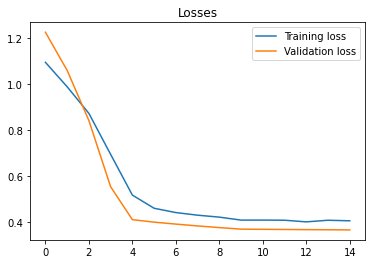

In [21]:
optimization_2.plot_losses()

Train loss 0.3361
(1800, 2)
torch.Size([1900, 100])


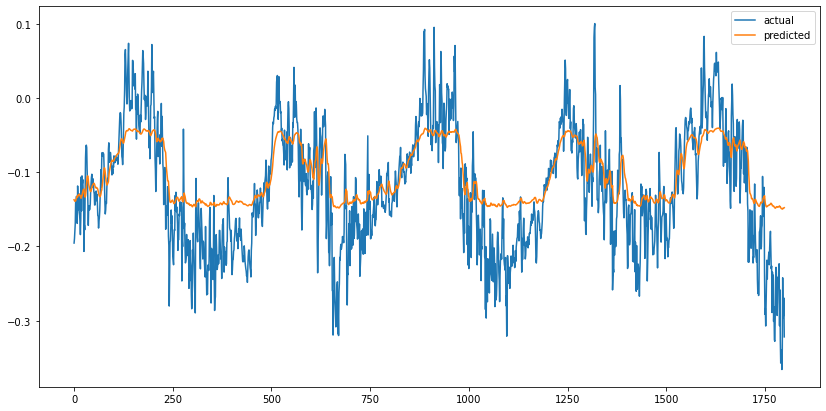

In [32]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_train, y_train, batch_size=100, future=5)
df_result_train = to_dataframe(actual_2, predicted_2)
df_result_train = inverse_transform(scaler, df_result_train, ["actual", "predicted"])
df_result_train.plot(figsize=(14, 7) )

print("Train loss %.4f" % test_loss_2)
print(df_result_train.shape)
print(y_train.shape)

Validation loss 0.3035


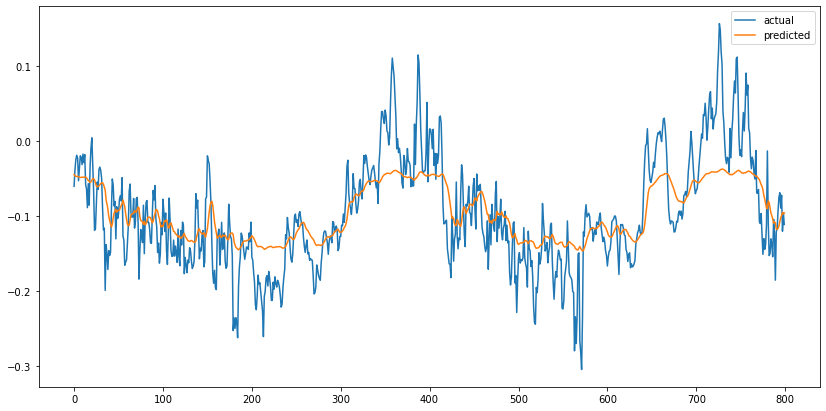

In [23]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_val, y_val, batch_size=100, future=5)
df_result_val = to_dataframe(actual_2, predicted_2)
df_result_val = inverse_transform(scaler, df_result_val, ["actual", "predicted"])
df_result_val.plot(figsize=(14, 7) )

print("Validation loss %.4f" % test_loss_2)

Test loss 0.2945


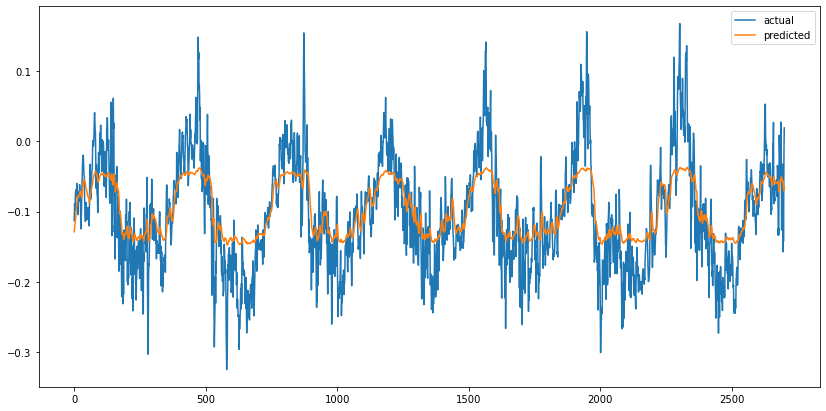

In [24]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
#print(x_test.shape)
df_result_test = to_dataframe(actual_2, predicted_2)
df_result_test = inverse_transform(scaler, df_result_test, ["actual", "predicted"])
df_result_test.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

Test loss 0.2945
(2700, 2)


(2700, 2)

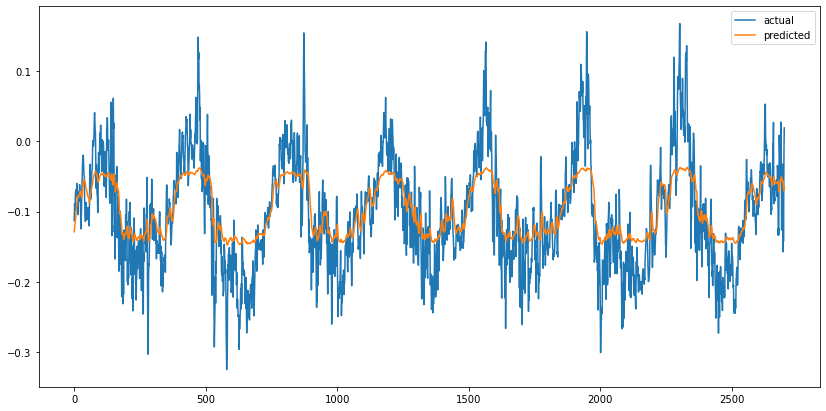

In [34]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
#print(x_test.shape)
df_result_test = to_dataframe(actual_2, predicted_2)
df_result_test = inverse_transform(scaler, df_result_test, ["actual", "predicted"])
df_result_test.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

combine=(df_result_train+df_result_val+df_result_test)
print(df_result_test.shape)
combine.shape

In [25]:
xtrainer = x_train.numpy()
print(xtrainer.shape)
print(df_result_train.shape)
#gets the shape 1800 from running windows of size 100 over 1900 points, the 2 is because there is an actual and predicted value

(1900, 100)
(1800, 2)


In [61]:
df_result_test

,actual,predicted
0,-0.113033,-0.128766
1,-0.109124,-0.126416
2,-0.088648,-0.123949
3,-0.098983,-0.119666
4,-0.089694,-0.116783
...,...,...
2695,-0.079035,-0.063851
2696,-0.142187,-0.064238
2697,-0.067858,-0.070506
2698,-0.011012,-0.069061


(1800,)

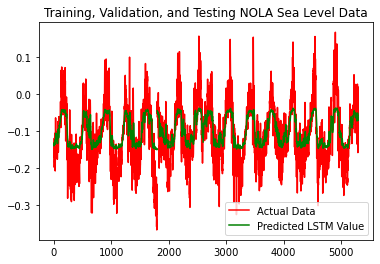

In [60]:
plt.plot(np.arange(len(df_result_train['actual'])),df_result_train['actual'], '-r'  )
plt.plot(np.arange(len(df_result_val['actual']))+len(df_result_train['actual']) , df_result_val['actual'], '-r'  )
plt.plot(np.arange(len(df_result_test['actual']))+len(df_result_train['actual'])+ len(df_result_val['actual'])  , df_result_test['actual'], '-r', label='Actual Data'  )
plt.plot(np.arange(len(df_result_train['predicted'])),df_result_train['predicted'], '-g' , label='Predicted LSTM Value' )
plt.plot(np.arange(len(df_result_val['predicted']))+len(df_result_train['predicted']) , df_result_val['predicted'], '-g'  )
plt.plot(np.arange(len(df_result_test['predicted']))+len(df_result_train['predicted'])+ len(df_result_val['predicted'])  , df_result_test['predicted'] , '-g' )
plt.title('Training, Validation, and Testing NOLA Sea Level Data')
plt.legend()
df_result_train['actual'].shape


Text(0.5, 0.98, 'Training and Testing NOLA Sea Level Data')

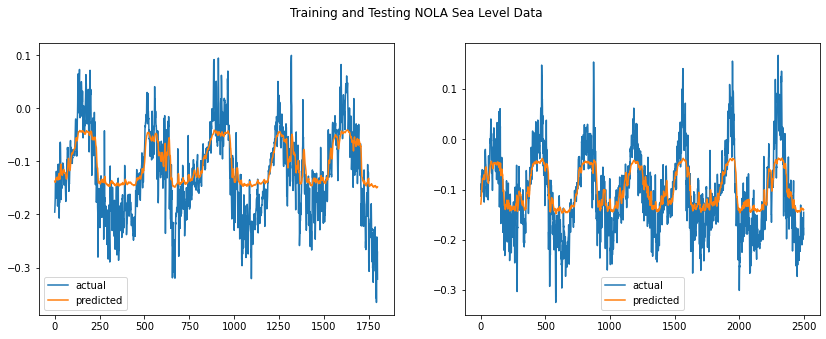

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_train.iloc[0:2000].plot(ax=axes[0], figsize=(14, 5))
df_result_test.iloc[0:2500].plot(ax=axes[1], figsize=(14, 5))
plt.suptitle('Training and Testing NOLA Sea Level Data')

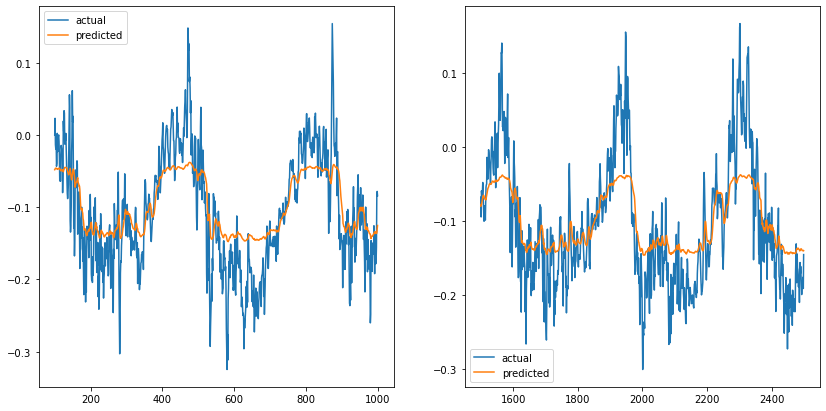

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_test.iloc[100:1000].plot(ax=axes[0], figsize=(14, 7))
df_result_test.iloc[1500:2500].plot(ax=axes[1], figsize=(14, 7))